## Emotion_Datasets 

In [31]:
# Imports 

import numpy as np 
import pandas as pd 
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import glob
import json
# import flirt
# import flirt.reader.empatica
# import flirt.with_



### VREED

In [32]:
# #Import VREED Dataset

# #Questionnaires 
# VREEDpreQ = pd.read_excel('/Users/emilydoherty/Desktop/IRES/Emotion_Datasets/VREED/Self-Reported Questionnaires/Participant Profile  Pre-Exposure Ratings.xlsx')
# VREEDpostQ=pd.read_excel('/Users/emilydoherty/Desktop/IRES/Emotion_Datasets/VREED/Self-Reported Questionnaires/Post Exposure Ratings.xlsx')

# #Features (min, max, etc.)
# VREEDeye=pd.read_csv('/Users/emilydoherty/Desktop/IRES/Emotion_Datasets/VREED/Eye Tracking Data/Eye Tracking Data (Features Extracted)/EyeTracking_FeaturesExtracted.csv')
# VREEDecg=pd.read_csv('/Users/emilydoherty/Desktop/IRES/Emotion_Datasets/VREED/ECG-GSR Data/ECG-GSR (Features Extracted)/ECG_FeaturesExtracted.csv')
# VREEDgsr=pd.read_csv('/Users/emilydoherty/Desktop/IRES/Emotion_Datasets/VREED/ECG-GSR Data/ECG-GSR (Features Extracted)/GSR_FeaturesExtracted.csv')


### AVReality 
this dataset will need to be filtered - hopefully use same filtering techniques as CEAP to extract features once that script is debugged

In [33]:
# AV Reality Data
AVRq=pd.read_excel('/Users/emilydoherty/IRES-EmotionNN/AVReality/Data_new.xlsx',sheet_name="Sheet1")
AVRq['ID']=AVRq['ID'].astype(str)
AVRq.describe()
AVRq.head()

,ID,Age:,Sex:,ERQ,N_Valence,N_Arousal,N_Dominance,N_EMFACS,N_Realism,N_Appeal,...,N_Trustworthy,S_Valence,S_Arousal,S_Dominance,S_EMFACS,S_Realism,S_Appeal,S_Familiar,S_Friendly,S_Trustworthy
0,S01,22,Male,Cognitive Reappraisal,5,3,7,Happiness,6,3,...,7,4,3,7,Disgust,7,4,7,7,6
1,S02,22,Female,Cognitive Reappraisal,7,4,6,Happiness,6,4,...,4,4,6,4,Anger,6,3,6,5,6
2,S03,19,Male,Expressive Suppression,7,4,6,Happiness,6,6,...,5,4,5,6,Sadness,6,6,6,6,6
3,S04,27,Male,Expressive Suppression,9,5,3,Happiness,5,3,...,4,3,6,7,Anger,4,6,7,6,4
4,S05,20,Male,Cognitive Reappraisal,6,4,9,Sadness,6,4,...,3,7,6,9,Anger,6,4,5,5,2


In [34]:
#Nature GSR Files 
path = '/Users/emilydoherty/IRES-EmotionNN/AVReality/E4/Nature/GSR'
csv_files = glob.glob(path + "/*.csv")
csv_files=sorted(csv_files)

import scipy.signal as signal

# low-pass filter and normalization
def SignalTrans(_signalList, order, cutoff):
    wn = 2 * cutoff / 4
    b, a = signal.butter(order, wn, 'lowpass')
    filterY = signal.filtfilt(b, a, _signalList)

    _range = np.max(filterY) - np.min(filterY)
    filterY1 = (filterY - np.min(filterY)) / _range
    return filterY1

# EDA changes
def EDA_Vary(_signalList, wn):  
    _velocityList = [0]
    for i in range(1, len(_signalList)):
        _v = (_signalList[i] - _signalList[i - 1]) / wn
        _velocityList.append(abs(_v))
    return _velocityList

# Z-score
def z_score_normalization(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

# Read each CSV file into DataFrame
# This creates a list of dataframes
N_GSR=[]

for file in csv_files:
	df_list = (pd.read_csv(file))
	df_list['filename']= os.path.basename(file)
	df_list['cond']= 'Nature'
	df_list['ID']= df_list['filename'].str.replace("_GSR_Nature.csv"," ")
	df_list['filtered'] = SignalTrans(df_list['Channel 1'],3,0.5)
	df_list['vary'] = EDA_Vary(df_list['filtered'],0.25)
	df_list['mean_GSR']=np.mean(df_list['vary'])
	# df_list['zscore']=z_score_normalization(df_list['vary']) 
	N_GSR.append(df_list)
        

N_GSR = pd.concat(N_GSR)
N_GSR = N_GSR[['ID','cond','mean_GSR']].drop_duplicates()


In [35]:
#Subway GSR Files 
path = '/Users/emilydoherty/IRES-EmotionNN/AVReality/E4/Subway/GSR'
csv_files = glob.glob(path + "/*.csv")
csv_files=sorted(csv_files)

# Read each CSV file into DataFrame
# This creates a list of dataframes
S_GSR=[]

for file in csv_files:
	df_list = (pd.read_csv(file))
	df_list['filename']= os.path.basename(file)
	df_list['ID']= df_list['filename'].str.replace("_GSR.csv"," ")
	df_list['cond']= 'Subway'
	df_list['filtered'] = SignalTrans(df_list['Channel 1'],3,0.5)
	df_list['vary'] = EDA_Vary(df_list['filtered'],0.25)
	df_list['mean_GSR']=np.mean(df_list['vary'])
	# df_list['zscore']=z_score_normalization(df_list['vary']) 
	S_GSR.append(df_list)
        
S_GSR = pd.concat(S_GSR)
S_GSR = S_GSR[['ID','cond','mean_GSR']].drop_duplicates()


In [36]:
#All GSR data
ALL_GSR= N_GSR.merge(S_GSR, on='ID')
# N_GSR.set_index('ID')
# AVRq.set_index('ID')
# N_GSR2=N_GSR.merge(AVRq, left_on='ID', right_on='ID', how='right')
# N_GSR2.to_excel('N_GSR2.xlsx')
# N_GSR.to_excel('N_GSR.xlsx')
# AVRq.to_excel('AVRq.xlsx')

# ALL_GSR.to_excel('ALL_GSR.xlsx')

In [37]:
#Nature BVP Files 
path = '/Users/emilydoherty/IRES-EmotionNN/AVReality/E4/Nature/BVP'
csv_files = glob.glob(path + "/*.csv")
csv_files=sorted(csv_files)

# Read each CSV file into DataFrame
# This creates a list of dataframes
N_BVP=[]
for file in csv_files:
	df_list = (pd.read_csv(file))
	df_list['filename']= os.path.basename(file)
	df_list['ID']= df_list['filename'].str.replace("_BVP_Nature.csv"," ")
	df_list['cond']= 'Nature'
	df_list['filtered'] = SignalTrans(df_list['Channel 1'],3,0.5)
	df_list['mean_BVP']=np.mean(df_list['filtered'])
	# df_list['zscore']=z_score_normalization(df_list['filtered']) 
	N_BVP.append(df_list)
	
N_BVP = pd.concat(N_BVP)
N_BVP = N_BVP[['ID','cond','mean_BVP']].drop_duplicates()

In [38]:
#Subway BVP Files 
path = '/Users/emilydoherty/IRES-EmotionNN/AVReality/E4/Subway/BVP'
csv_files = glob.glob(path + "/*.csv")
csv_files=sorted(csv_files)

# Read each CSV file into DataFrame
# This creates a list of dataframes
S_BVP=[]
for file in csv_files:
	df_list = (pd.read_csv(file))
	df_list['filename']= os.path.basename(file)
	df_list['ID']= df_list['filename'].str.replace("_BVP.csv"," ")
	df_list['cond']= 'Subway'
	df_list['filtered'] = SignalTrans(df_list['Channel 1'],3,0.5)
	df_list['mean_BVP']=np.mean(df_list['filtered'])
	df_list['zscore']=z_score_normalization(df_list['filtered']) 
	S_BVP.append(df_list)
	
S_BVP = pd.concat(S_BVP)
S_BVP = S_BVP[['ID','cond','mean_BVP']].drop_duplicates()

In [39]:
#All Blood Vol Pulse data
ALL_BVP= N_BVP.merge(S_BVP, on='ID')


In [40]:
#Nature TMP Files 
path = '/Users/emilydoherty/IRES-EmotionNN/AVReality/E4/Nature/TMP'
csv_files = glob.glob(path + "/*.csv")
csv_files=sorted(csv_files)

# Read each CSV file into DataFrame
# This creates a list of dataframes
N_TMP=[]
for file in csv_files:
	df_list = (pd.read_csv(file))
	df_list['filename']= os.path.basename(file)
	df_list['ID']= df_list['filename'].str.replace("_TMP_Nature.csv"," ")
	df_list['cond']= 'Nature'
	df_list['filtered'] = SignalTrans(df_list['Channel 1'],3,0.5)
	df_list['mean_TMP']=np.mean(df_list['filtered'])
	df_list['zscore']=z_score_normalization(df_list['filtered']) 
	N_TMP.append(df_list)
	
N_TMP = pd.concat(N_TMP)
N_TMP = N_TMP[['ID','cond','mean_TMP']].drop_duplicates()


/var/folders/s5/2vb14g7n453_16xv4yf0wrv40000gn/T/ipykernel_86835/595981692.py:15: RuntimeWarning: invalid value encountered in divide
  filterY1 = (filterY - np.min(filterY)) / _range


In [41]:
#Subway TMP Files 
path = '/Users/emilydoherty/IRES-EmotionNN/AVReality/E4/Subway/TMP'
csv_files = glob.glob(path + "/*.csv")
csv_files=sorted(csv_files)

# Read each CSV file into DataFrame
# This creates a list of dataframes
S_TMP=[]
for file in csv_files:
	df_list = (pd.read_csv(file))
	df_list['filename']= os.path.basename(file)
	df_list['ID']= df_list['filename'].str.replace("_TMP.csv"," ")
	# df_list['ID']= df_list['filename'].str.split("_TMP.csv",n=1,expand = False)
	df_list['cond']= 'Subway'
	df_list['filtered'] = SignalTrans(df_list['Channel 1'],3,0.5)
	df_list['mean_TMP']=np.mean(df_list['filtered'])
	df_list['zscore']=z_score_normalization(df_list['filtered']) 
	S_TMP.append(df_list)
	
S_TMP = pd.concat(S_TMP)
S_TMP = S_TMP[['ID','cond','mean_TMP']].drop_duplicates()

/var/folders/s5/2vb14g7n453_16xv4yf0wrv40000gn/T/ipykernel_86835/595981692.py:15: RuntimeWarning: invalid value encountered in divide
  filterY1 = (filterY - np.min(filterY)) / _range


In [42]:
#All TMP data
ALL_TMP= N_TMP.merge(S_TMP, on='ID')
N_ALL=N_TMP.merge(N_GSR, on=['ID','cond']).merge(N_BVP,on=['ID','cond'])
N_ALL.to_excel('N_ALL.xlsx')

In [43]:
S_ALL=S_TMP.merge(S_GSR, on=['ID','cond']).merge(S_BVP,on=['ID','cond'])
S_ALL.to_excel('S_ALL.xlsx')

In [44]:
S_ALL=pd.read_excel('/Users/emilydoherty/IRES-EmotionNN/AVReality/S_ALL copy.xlsx')
N_ALL=pd.read_excel('/Users/emilydoherty/IRES-EmotionNN/AVReality/N_ALL copy.xlsx')


###CEAP

In [45]:
###RUN this in terminal   LEFT OFF HERE TRYING TO RUN THIS SCRIPT

# cd '/Users/emilydoherty/Desktop/IRES/Emotion_Datasets/CEAP-360VR-Dataset-master/CEAP-360VR/6_Scripts/2_Data Processed'
# python3 


In [46]:
#Import CEAP Data

# Post-processed .csv
# CEAPpost=pd.read_csv('/Users/emilydoherty/Desktop/Data Jupyter Notebook_NEW/temp/ceap_example/Dataset_CEAP_postprocessed.csv')

#Load CEAP Features .csv
#got these features by editing script to extract features in the CEAP folder, include mean/med/std of each measure 
# Get CSV files list from a folder
path = '/Users/emilydoherty/IRES-EmotionNN/CEAP360/Features/'
csv_files = glob.glob(path + "*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames into one 
CEAPfeatures= pd.concat(df_list, ignore_index=True)
CEAPfeatures_parsed = CEAPfeatures[['EDA_Mean', 'SKT_Mean', 'BVP_Mean', 'HR_Mean' ,'V_binary']].copy() ###continue here


In [47]:
CEAPfeatures_parsed.describe()

,EDA_Mean,SKT_Mean,BVP_Mean,HR_Mean,V_binary
count,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000
mean,-4.702913,5.149819,-6.704183,5.273288,0.594727
std,10.950086,2.259456,48.025534,2.485801,0.491025
min,-69.528895,1.000000,-152.907475,1.000000,0.000000
25%,-9.513263,3.781896,-31.596526,3.447941,0.000000
50%,-4.472074,5.000000,-2.395364,5.026945,1.000000
75%,0.431612,6.606881,17.500847,7.383758,1.000000
max,65.856645,9.000000,169.225876,9.000000,1.000000


### VRFS


In [48]:
#maybe
#run in terminal : pip install flirt
#EDA 
from glob import glob as glob
paths = ["/Users/emilydoherty/IRES-EmotionNN/VRFS/Data/Physiological Signal/Phasmophobia", "/Users/emilydoherty/IRES-EmotionNN/VRFS/Data/Physiological Signal/Warthunder", "/Users/emilydoherty/IRES-EmotionNN/VRFS/Data/Physiological Signal/Minecraft", "/Users/emilydoherty/IRES-EmotionNN/VRFS/Data/Physiological Signal/Dirt Rally"]
eda_VR = []
for path in paths:
  for participant in glob(path + "/*/VR", recursive = True):
    p = glob(participant+"/EDA.csv")[0]
    # eda_VR.append(flirt.reader.empatica.read_eda_file_into_df(p)["eda"])
    df_list = (pd.read_csv(p))
    df_list['PID']=participant
    df_list.rename(columns={df_list.columns[0]: 'GSR'},inplace=True)
    df_list['filtered'] = SignalTrans(df_list['GSR'],3,0.5)
    df_list['vary'] = EDA_Vary(df_list['filtered'],0.25)
    df_list['mean_GSR']=np.mean(df_list['vary'])
    eda_VR.append(df_list)
        
eda_VR = pd.concat(eda_VR)
eda_VR = eda_VR[['mean_GSR']].drop_duplicates()
eda_VR['ID']=[27, 28, 29, 30, 31, 32, 33, 34, 1, 2, 3, 4, 14, 24, 35, 8, 9, 13, 14, 15, 16, 17, 18, 19, 5, 6, 19, 20, 21, 22, 23, 25, 26]


In [49]:
#BVP
BVP_VR=[]
for path in paths:
	for participant in glob(path + "/*/VR", recursive = True):
		p = glob(participant+"/BVP.csv")[0]
		df_list = (pd.read_csv(p))
		df_list.rename(columns={df_list.columns[0]: 'BVP'},inplace=True)	
		df_list['filtered'] = SignalTrans(df_list['BVP'],3,0.5)
		df_list['mean_BVP']=np.mean(df_list['filtered'])
		BVP_VR.append(df_list)
	
BVP_VR = pd.concat(BVP_VR)
BVP_VR = BVP_VR['mean_BVP'].drop_duplicates()

BVP_VR['ID']=[27, 28, 29, 30, 31, 32, 33, 34, 1, 2, 3, 4, 14, 24, 35, 8, 9, 13, 14, 15, 16, 17, 18, 19, 5, 6, 19, 20, 21, 22, 23, 25, 26]


In [50]:
#TMP
TMP_VR=[]
for path in paths:
  for participant in glob(path + "/*/VR", recursive = True):
    p = glob(participant+"/TEMP.csv")[0]
    df_list = (pd.read_csv(p))
    df_list.rename(columns={df_list.columns[0]: 'TMP'},inplace=True)
    df_list['ID']= (participant.strip('/VR')).strip(path)
    df_list['filtered'] = SignalTrans(df_list['TMP'],3,0.5)
    df_list['mean_TMP']=np.mean(df_list['filtered'])
    TMP_VR.append(df_list)
	
TMP_VR = pd.concat(TMP_VR)
TMP_VR = TMP_VR['mean_TMP'].drop_duplicates()


In [51]:
TMP_VR['ID']=[27, 28, 29, 30, 31, 32, 33, 34, 1, 2, 3, 4, 14, 24, 35, 8, 9, 13, 14, 15, 16, 17, 18, 19, 5, 6, 19, 20, 21, 22, 23, 25, 26]

In [52]:
SAM = pd.read_csv('/Users/emilydoherty/IRES-EmotionNN/VRFS/Data/Psychological Signal/SAM.csv')
SAM = SAM[SAM.Type != 'FS']
SAM['ID']=[5, 6, 19, 20, 21, 22, 23, 25, 26, 1, 2, 3, 4, 14, 24, 35,27, 28, 29, 30, 31, 32, 33, 34,8, 9, 13, 14, 15, 16, 17, 18, 19]
SAM2 = pd.merge(SAM, eda_VR)


In [53]:
N_ALL.drop(columns=N_ALL.columns[0], axis=1, inplace=True)
N_ALL.describe()

,mean_TMP,mean_GSR,mean_BVP,Age:,N_Valence,N_Arousal,N_Dominance,N_Realism,N_Appeal,N_Familiar,N_Friendly,N_Trustworthy
count,26.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.474564,0.089285,0.450063,21.444444,6.814815,3.370370,6.259259,4.666667,4.962963,5.370370,5.518519,5.370370
std,0.071692,0.357216,0.073038,2.025479,1.177907,1.944383,1.933363,1.300887,1.400041,1.547905,1.424251,1.445102
min,0.316678,0.004749,0.314825,19.000000,5.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,3.000000
25%,0.432743,0.008251,0.398688,20.000000,6.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000
50%,0.470704,0.018737,0.458371,21.000000,7.000000,3.000000,7.000000,5.000000,5.000000,5.000000,6.000000,5.000000
75%,0.514920,0.028188,0.490778,22.000000,7.500000,4.500000,8.000000,6.000000,6.000000,7.000000,7.000000,7.000000
max,0.633773,1.875000,0.601381,27.000000,9.000000,8.000000,9.000000,6.000000,7.000000,7.000000,7.000000,7.000000


### Constructing Neural Network

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [55]:
N_ALL.shape

(27, 17)

In [56]:
N_ALL=N_ALL.dropna()

In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

X = N_ALL.copy()
#Need to binarize N_Valence  (median split)
X["N_Valence_Binary"] = (X.N_Valence<X.N_Valence.quantile()).replace({True:1, False:0})
X = X.drop(['ID','cond','N_Valence'],axis=1)
# Remove target
y= X.pop('N_Valence_Binary') #lets try to classify valence


In [58]:
#Need to see which variables are categorical vs. not for one-hot encoding
X.dtypes


mean_TMP         float64
mean_GSR         float64
mean_BVP         float64
Age:               int64
Sex:              object
ERQ               object
N_Arousal          int64
N_Dominance        int64
N_EMFACS          object
N_Realism          int64
N_Appeal           int64
N_Familiar         int64
N_Friendly         int64
N_Trustworthy      int64
dtype: object

In [59]:
#make sure all numerical values fall under np.number class
# X.select_dtypes(include = np.number).head ()

In [60]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
input_shape = [X_train.shape[1]]
input_shape

[19]

In [75]:
#NN Code

from tensorflow import keras
from tensorflow.keras import layers
# import BatchNormalization

model1 = Sequential()
model1.add(Dense(64,activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(rate=0.3))
model1.add(Dense(1, activation='sigmoid'))



In [76]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=2, mode='auto', restore_best_weights=True)

In [77]:
model1.compile(optimizer='adam',     loss='binary_crossentropy', 
    metrics=['accuracy'])

history = model1.fit(X_train, y_train, 
    validation_data= (X_test,y_test),
    epochs=100,
    batch_size=128, 
    callbacks=[monitor])

Epoch 1/100
1/1 [==============================] - 0s 221ms/step - loss: 0.6868 - accuracy: 0.4706 - val_loss: 0.6741 - val_accuracy: 0.7778
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6588 - accuracy: 0.5882 - val_loss: 0.6657 - val_accuracy: 0.7778
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6457 - accuracy: 0.6471 - val_loss: 0.6578 - val_accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6171 - accuracy: 0.7059 - val_loss: 0.6508 - val_accuracy: 0.6667
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6175 - accuracy: 0.6471 - val_loss: 0.6443 - val_accuracy: 0.6667
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5702 - accuracy: 0.6471 - val_loss: 0.6383 - val_accuracy: 0.6667
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6196 - accuracy: 0.6471 - val_loss: 0.6327 - val_accuracy: 0.6667
Epoch 8/100
1/1 [==

In [85]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                1280      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5505 (21.50 KB)
Trainable params: 5505 (21.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
import importlib
import info5604_utils as util
importlib.reload(util)

<module 'info5604_utils' from '/Users/emilydoherty/IRES-EmotionNN/info5604_utils.py'>

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

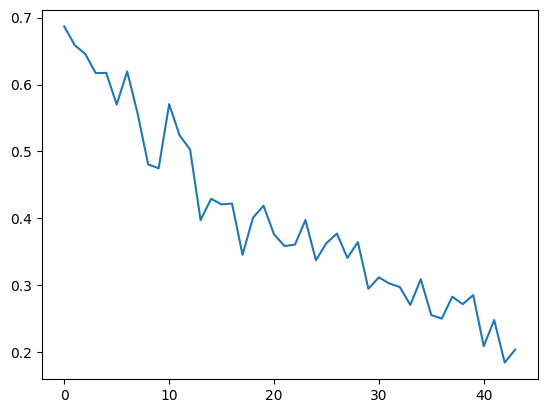

In [87]:
util.plot_history(history)

In [80]:
hist=pd.DataFrame(history.history)
hist

,loss,accuracy,val_loss,val_accuracy
0,0.686825,0.470588,0.674134,0.777778
1,0.658815,0.588235,0.665705,0.777778
2,0.645716,0.647059,0.657827,0.666667
3,0.617110,0.705882,0.650819,0.666667
4,0.617484,0.647059,0.644299,0.666667
5,0.570177,0.647059,0.638260,0.666667
6,0.619589,0.647059,0.632731,0.666667
7,0.556498,0.764706,0.627720,0.666667
8,0.480702,0.882353,0.623065,0.666667
9,0.474759,0.823529,0.618959,0.666667


In [81]:
train_acc = model1.evaluate(X_train, y_train, verbose=0)
test_acc = model1.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


TypeError: must be real number, not list

In [ ]:
model.evaluate(test_dset)

In [82]:
pred = model1.predict(test_dset)
pred_label = np.argmax(pred, axis=1)
cmat = confusion_matrix(y_test, pred_label, normalize='true')

NameError: name 'test_dset' is not defined

In [ ]:
sb.heatmap(cmat, yticklabels=category_labels, xticklabels=category_labels)